To tutaj sprawdza proste parametry żeby sprawdzić czy skrypt działa dobrze.
Bardziej skomplikowane siatki wrzucać na kaggla po dopasowaniu i dobraniu danych -
trzeba zmienić nazwe pliku tutaj niżej

In [20]:
# nazwy outputów
TITLE = 'bagging'

# ścieżka do pliku z danymi
DATA_PATH = '../dataset.reduced.csv'

# ilość kroswalidacji
CROSS_VAL_N = 3

# nazwa pliku csv z wynikami z innych eksperymentów do wykresu punktowego
OTHER_SCORES_CSV_PATERN = 'bagging'

GRID = {
    'regressor__n_estimators': [10],
    'regressor__max_samples': [0.5],
    'regressor__max_features': [0.5],
    'regressor__bootstrap': [True],
    'regressor__bootstrap_features': [True],
    'regressor__oob_score': [False],
    'regressor__warm_start': [False]
}

In [21]:
"""Wczytanie"""
from pandas import read_csv
df = read_csv(DATA_PATH, low_memory=False).drop(columns=[
    'free_month', 'free_year', 
    'district_lat', 'district_lon', 'district_name',
    'city_name'
], axis=1)

X = df.drop('price', axis=1)
y = df['price']
del df

In [22]:
"""Podział"""
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X, y

KeyboardInterrupt: 

In [ ]:
"""Preproes NA = mediana | 0"""
cat = train.select_dtypes(include='object').columns
fill_med = ['year', 'rooms', 'floor']
fill_0 = ['area_outside', 'rent']
passthrough = [c for c in train.columns if c not in [*fill_med, *fill_0, *cat]]
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
pre_med_0 = ColumnTransformer(transformers=[    
    ('encode', Pipeline(steps=[('encoder', OneHotEncoder())]), cat),
    ('fill_med', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), fill_med),
    ('fill_0', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0))]), fill_0),
    ('passthrough', make_pipeline('passthrough'), passthrough)
])

In [ ]:
"""Model"""
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', pre_med_0),
    ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor()))
])

In [ ]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipeline, GRID, cv=CROSS_VAL_N, scoring='neg_mean_absolute_error', n_jobs=6)
search.fit(train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('encode',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['category', 'market', 'material', 'status', 'type', 'windows'], dtype='object')),
                                                                        ('fill_med',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['year',
                                                                          'rooms',
                                                                          'floor']),
                                                                        ('fill_0',
                                                                         Pipeline...
                                       ('regressor',
                                        BaggingRegressor(estimator=DecisionTreeRegressor()))]),
             n_jobs=6,
             param_grid={'regressor__bootstrap': [True],
                         'regressor__bootstrap_features': [True],
                         'regressor__max_features': [0.5],
                         'regressor__max_samples': [0.5],
                         'regressor__n_estimators': [10],
                         'regressor__oob_score': [False],
                         'regressor__warm_start': [False]},
             scoring='neg_mean_absolute_error')

In [ ]:
"""Migawka modelu"""
model = search.best_estimator_
import pickle
with open(f'{TITLE}.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
"""Wyniki innych modeli dla porównania"""
import glob
from pandas import read_csv, concat, DataFrame
cv_scores_other = DataFrame()
for file_name in glob.glob(f'{OTHER_SCORES_CSV_PATERN}.*.csv'):
    cv_scores_other = concat([cv_scores_other, read_csv(file_name)])

In [ ]:
from pandas import DataFrame, to_numeric
cv_scores = DataFrame(search.cv_results_).drop('params', axis=1)
cv_scores = cv_scores.apply(to_numeric, errors='coerce')
cv_scores.to_csv(f'{TITLE}.csv')
cv_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__bootstrap_features,param_regressor__max_features,param_regressor__max_samples,param_regressor__n_estimators,param_regressor__oob_score,param_regressor__warm_start,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,34.95891,1.131929,9.020675,0.24804,True,True,0.5,0.5,10,False,False,-104945.210613,-124166.051179,-109502.893777,-112871.38519,8200.415795,1


In [ ]:
def scatter_3d(df, 
    x_col, x_title, 
    y_col, y_title, 
    z_col, z_title, 
    size_col, size_title, 
    color_col, color_title, color_scale=None, 
    scatter=0.01
):

    from plotly.graph_objects import Figure, Scatter3d
    from numpy import random, log, mean

    fig = Figure(data=[Scatter3d(
        x=df[x_col] + mean(df[x_col]) * random.normal(0, scatter, size=len(df)),
        y=df[y_col] + mean(df[y_col]) * random.normal(0, scatter, size=len(df)),
        z=df[z_col] + mean(df[z_col]) * random.normal(0, scatter, size=len(df)),
        mode='markers',
        marker=dict(
            size=log(df[size_col]),
            sizemode='diameter',
            sizeref=.1,
            opacity=0.8,
            color=df[color_col],
            colorscale='thermal',
            colorbar=dict(title=color_title),
            cmin=color_scale[0] if color_scale else None,
            cmax=color_scale[1] if color_scale else None
        ),
        text=
            x_title + '=' + df[x_col].astype(str) + '; ' + 
            y_title + '=' + df[y_col].astype(str) + '; ' + 
            z_title + '=' + df[z_col].astype(str) + '; ' +
            ((size_title + '='+ df[size_col].astype(str) + '; ') if size_title else '') + 
            ((color_title + '='+ round(df[color_col],3).astype(str)) if color_col else ''),
        hoverinfo='text'
    )])

    fig.update_layout(
        title="Parametry i wyniki walidacji krzyżowej",
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=x_title,
            yaxis_title=y_title,
            zaxis_title=z_title
        )
    )
    
    return fig

In [ ]:
from pandas import concat
scatter_3d(concat([cv_scores, cv_scores_other]), 
    'param_regressor__n_estimators', 'liczba drzew',
    'param_regressor__max_features', 'liczba cech',
    'param_regressor__max_samples', 'rozmiar próbki',
    'param_regressor__n_estimators', '',
    'mean_test_score', 'średni wynik walidacji'
)

In [ ]:
"""Predykcje"""
from pandas import Series
pred_train = Series(model.predict(train))
pred_test = Series(model.predict(test))

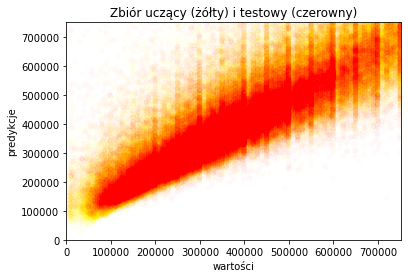

In [ ]:
"""Wykres predykcji"""
from pandas import DataFrame, Series
DataFrame({ 'y': [*y_train, *y_test], 'p': [*pred_train, *pred_test]}).plot(
    kind='scatter', 
    title="Zbiór uczący (żółty) i testowy (czerowny)",
    x='y', xlabel='wartości', xlim=(0, pred_test.quantile(.90)),
    y='p', ylabel='predykcje', ylim=(0, pred_test.quantile(.90)),
    c=Series(([0] * len(pred_train) + [1] * len(pred_test))).map({0: 'yellow', 1: 'red'}), 
    alpha=.01
);

In [ ]:
"""Punktacja"""
from sklearn import metrics
from numpy import sqrt
from pandas import DataFrame
test_scores = DataFrame({
    'R2': [metrics.r2_score(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'MSE': [metrics.mean_squared_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'RMSE': [sqrt(metrics.mean_squared_error(y_test, pred_test)), metrics.r2_score(y_train, pred_train)],
    'MAE': [metrics.mean_absolute_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'MAPE': [metrics.mean_absolute_percentage_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)]
},  index = ['test', 'train'])

test_scores.to_csv(f'test.{TITLE}.csv')
test_scores

,R2,MSE,RMSE,MAE,MAPE
test,0.018508,6.058852e+12,2.461474e+06,96838.336984,0.249811
train,0.533215,5.332152e-01,5.332152e-01,0.533215,0.533215


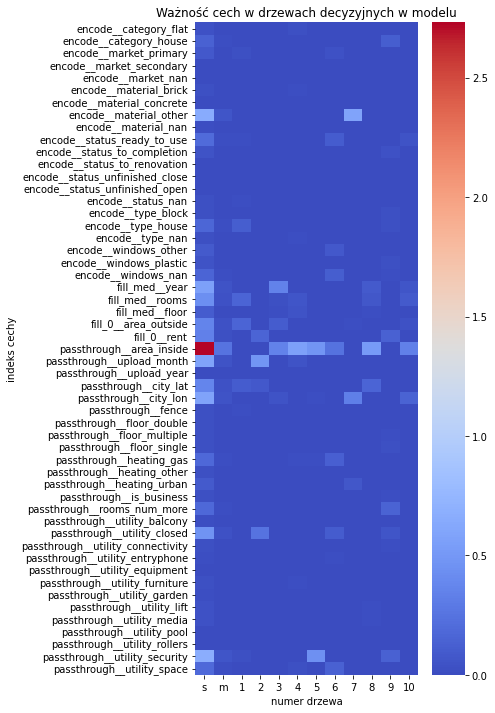

In [101]:
"""Ważność cech"""
def features_heatmap(bagging):
    from pandas import DataFrame
    from seaborn import heatmap
    from matplotlib.pyplot import figure

    names = model.named_steps['preprocessing'].get_feature_names_out()
    trees = bagging.named_steps['regressor'].estimators_

    tree_numbers = [f'{i+1}' for i in range(len(model.named_steps['regressor'].estimators_))]
    importance = DataFrame(index=names, columns=tree_numbers)
    for i_tree in range(len(trees)):
        
        tree = bagging.named_steps['regressor'].estimators_[i_tree]
        f_indices = bagging.named_steps['regressor'].estimators_features_[i_tree]
        
        importance.iloc[f_indices, i_tree] = tree.feature_importances_
        
    importance = importance.infer_objects(copy=False).fillna(0)
    importance['m'] = importance.mean(axis=1)
    importance['s'] = importance.sum(axis=1)
    importance = importance[['s', 'm'] + [col for col in importance if col not in ['m', 's']]]


    figure(figsize=(5, 12))
    ax = heatmap(importance, cmap='coolwarm')
    ax.set_ylabel('indeks cechy')
    ax.set_xlabel('numer drzewa')
    ax.set_title('Ważność cech w drzewach decyzyjnych w modelu')

    return importance

f_imp = features_heatmap(model)

In [114]:
"""Cechy średnio nieistotne"""
print(f_imp[f_imp['m'].round(2) == 0.0]['s'].index)

Index(['encode__category_flat', 'encode__market_secondary',
       'encode__market_nan', 'encode__material_brick',
       'encode__material_concrete', 'encode__material_nan',
       'encode__status_to_completion', 'encode__status_to_renovation',
       'encode__status_unfinished_close', 'encode__status_unfinished_open',
       'encode__status_nan', 'encode__type_block', 'encode__type_nan',
       'encode__windows_plastic', 'passthrough__upload_year',
       'passthrough__fence', 'passthrough__floor_double',
       'passthrough__floor_multiple', 'passthrough__floor_single',
       'passthrough__heating_other', 'passthrough__is_business',
       'passthrough__utility_balcony', 'passthrough__utility_connectivity',
       'passthrough__utility_entryphone', 'passthrough__utility_equipment',
       'passthrough__utility_furniture', 'passthrough__utility_garden',
       'passthrough__utility_lift', 'passthrough__utility_media',
       'passthrough__utility_pool', 'passthrough__utility_rollers

In [113]:
"""Cechy sumarycznie nieistotne"""
print(f_imp[f_imp['s'].round(2) == 0.0]['s'].index)

Index(['encode__category_flat', 'encode__market_secondary',
       'encode__market_nan', 'encode__material_brick',
       'encode__material_concrete', 'encode__material_nan',
       'encode__status_to_completion', 'encode__status_to_renovation',
       'encode__status_unfinished_close', 'encode__status_unfinished_open',
       'encode__status_nan', 'encode__type_block', 'encode__type_nan',
       'encode__windows_plastic', 'passthrough__upload_year',
       'passthrough__fence', 'passthrough__floor_double',
       'passthrough__floor_multiple', 'passthrough__floor_single',
       'passthrough__heating_other', 'passthrough__is_business',
       'passthrough__utility_balcony', 'passthrough__utility_connectivity',
       'passthrough__utility_entryphone', 'passthrough__utility_equipment',
       'passthrough__utility_furniture', 'passthrough__utility_garden',
       'passthrough__utility_lift', 'passthrough__utility_media',
       'passthrough__utility_pool', 'passthrough__utility_rollers